### **Importando as bibliotecas e bases de dados**

In [1]:
# Importando as bibliotecas
import sys
import pandas as pd                        
import numpy as np                             
import seaborn as sns                                 
import matplotlib.pyplot as plt   
from wordcloud import WordCloud
               
from sklearn.cluster import KMeans    
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA  
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [2]:
base_original = pd.read_csv("../data/data.csv")

### **1. Criando treino e teste, modelo, PCA, e normalizações**

#### **Explicações das etapas seguintes:**

- Separando a base em treino e teste, para simular a entrada de dados
- Criando um modelo KMeans de 5 clusters
- Criando um PCA de 1 componente para as colunas: acousticness, energy e loudness, que estão alto correlacionadas. Isso em uma base que tenha muitas features pode ser importante na redução de dimensionalidade.
- Instanciando normalizadores para padronizar a escala das colunas em 0 e 1

In [38]:
xtreino, xteste = train_test_split(base_original, test_size=0.10, random_state=10)

modelo_kmeans = KMeans(n_clusters=5, 
                init='k-means++', 
                n_init=50,
                max_iter=300,
                tol = 1e-4,
                random_state=0
                )

minmax_year = MinMaxScaler()
minmax_tempo = MinMaxScaler()
minmax_loudness = MinMaxScaler()

pca_acou_ener_loud = PCA(n_components=1)

minmax_pca = MinMaxScaler()



### **2. Criando o pipeline**

In [41]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer

def selecao_colunas(base):
    base = base[['year','tempo','acousticness','danceability','energy','instrumentalness','liveness','loudness','speechiness','valence']]
    return base

colunas_pca = ['acousticness','energy','loudness']
colunas_sem_pca = ['year','tempo','danceability','instrumentalness','liveness','speechiness','valence']

pca_pipeline = Pipeline(steps=[
    ('scaler_loudness', minmax_loudness),  
    ('pca', PCA(n_components=1)),
       
])

col_pipeline = Pipeline(steps=[
    ('scaler_year', minmax_year),
    ('scaler_tempo', minmax_tempo),
])

preprocessamento = ColumnTransformer(transformers=[
    ('pca', pca_pipeline, colunas_pca),
    ('cols', col_pipeline, colunas_sem_pca)
])

pipeline = Pipeline(steps=[
    ("selecao_colunas", FunctionTransformer(selecao_colunas)),
    ('preprocessamento', preprocessamento),
    ('modelo_cluster', modelo_kmeans)
])

In [42]:
pipeline.fit(xtreino)

Pipeline(steps=[('selecao_colunas',
                 FunctionTransformer(func=<function selecao_colunas at 0x000002631C008FE0>)),
                ('preprocessamento',
                 ColumnTransformer(transformers=[('pca',
                                                  Pipeline(steps=[('scaler_loudness',
                                                                   MinMaxScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=1))]),
                                                  ['acousticness', 'energy',
                                                   'loudness']),
                                                 ('cols',
                                                  Pipeline(steps=[('scaler_year',
                                                                   MinMaxScaler()),
                                                                  ('scaler_tempo',
                                                                   MinMaxScaler())]),
                                                  ['year', 'tempo',
                                                   'danceability',
                                                   'instrumentalness',
                                                   'liveness', 'speechiness',
                                                   'valence'])])),
                ('modelo_cluster',
                 KMeans(n_clusters=5, n_init=50, random_state=0))])

In [43]:
pipeline.predict(xtreino)

array([2, 1, 1, ..., 2, 2, 1])

In [44]:
xtreino['Cluster'] = pipeline.predict(xtreino)
xtreino

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,Cluster
34622,0.168,2000,0.26100,['Radiohead'],0.630,284507,0.4290,0,4x7XJOE2ml2P3o3i77466j,0.850000,5,0.3090,-15.540,1,Kid A,56,2000-10-01,0.0356,112.930,2
100624,0.881,1979,0.05700,['The Cure'],0.531,201413,0.8700,0,1t28HJVBCD73OrRItUraIc,0.000090,10,0.1400,-4.298,0,I'm Cold - Sav Studio Demo 11/77,25,1979-05-11,0.0423,158.539,1
104992,0.971,2001,0.34600,['Paco Barrón y sus Norteños Clan'],0.682,156413,0.9190,0,4M4x8C8Zcqw3RB5TvParIK,0.000273,9,0.0922,-6.122,1,Directo Al Corazón,45,2001-01-01,0.0876,176.165,1
67800,0.848,1983,0.22100,['Genesis'],0.610,266307,0.4190,0,3xaBJGjMnrbuu2wlI5itEv,0.009640,4,0.0506,-15.334,0,That's All - Single Version,31,1983,0.0423,175.255,1
86853,0.781,1993,0.73400,['Matecana Orquesta'],0.734,289097,0.5210,0,09zJAF4Z2v55rU9XXZfA9N,0.000058,10,0.3960,-11.712,1,Gracias Amor,58,1993-01-01,0.0405,90.788,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9372,0.344,1968,0.93400,['Buffalo Springfield'],0.687,255773,0.1940,0,4o6jfrxQyekM5DpnWYLlMo,0.000491,9,0.1380,-13.177,1,Kind Woman,46,1968,0.0300,105.278,3
105595,0.368,2004,0.00111,['Dave Armstrong'],0.490,171280,0.9550,0,2Ug4PnkxcwkcL3fhM0B9Xe,0.063000,5,0.0375,-3.230,0,Make Your Move - Radio Edit,44,2004-06-22,0.3710,127.963,4
93553,0.084,1942,0.99200,"['Franz Liszt', 'Oscar Levant']",0.483,186053,0.0766,0,58mcD0dYrT2jjngm3Y0DWh,0.877000,11,0.0745,-19.477,1,"Valses oubliées, S. 215, No. 1",0,1942,0.0485,76.009,2
94735,0.444,1950,0.86800,"['Leonard Bernstein', 'New York Philharmonic']",0.360,278000,0.2850,0,0f0lSufKlmwd85jQTsgCEU,0.858000,5,0.0540,-16.270,1,"On the Town: Times Square, 1944",0,1950,0.0500,94.912,2


In [47]:
xteste['Cluster'] = pipeline.predict(xteste)

In [48]:
xteste.Cluster.value_counts()

Cluster
3    5293
1    4583
4    4113
2    2495
0     582
Name: count, dtype: int64

In [49]:
xtreino.Cluster.value_counts()

Cluster
3    47808
1    41406
4    36511
2    22975
0     4887
Name: count, dtype: int64

#### **Visualizando as palavras presentes nos nomes das músicas, por Cluster - Base de treino**

In [50]:
cluster_0 = xtreino.loc[xtreino['Cluster'] == 0, "name"].to_list()
cluster_1 = xtreino.loc[xtreino['Cluster'] == 1, "name"].to_list()
cluster_2 = xtreino.loc[xtreino['Cluster'] == 2, "name"].to_list()
cluster_3 = xtreino.loc[xtreino['Cluster'] == 3, "name"].to_list()
cluster_4 = xtreino.loc[xtreino['Cluster'] == 4, "name"].to_list()

nuvem_cluster_0 = ''.join(map(str, cluster_0))
nuvem_cluster_1 = ''.join(map(str, cluster_1))
nuvem_cluster_2 = ''.join(map(str, cluster_2))
nuvem_cluster_3 = ''.join(map(str, cluster_3))
nuvem_cluster_4 = ''.join(map(str, cluster_4))

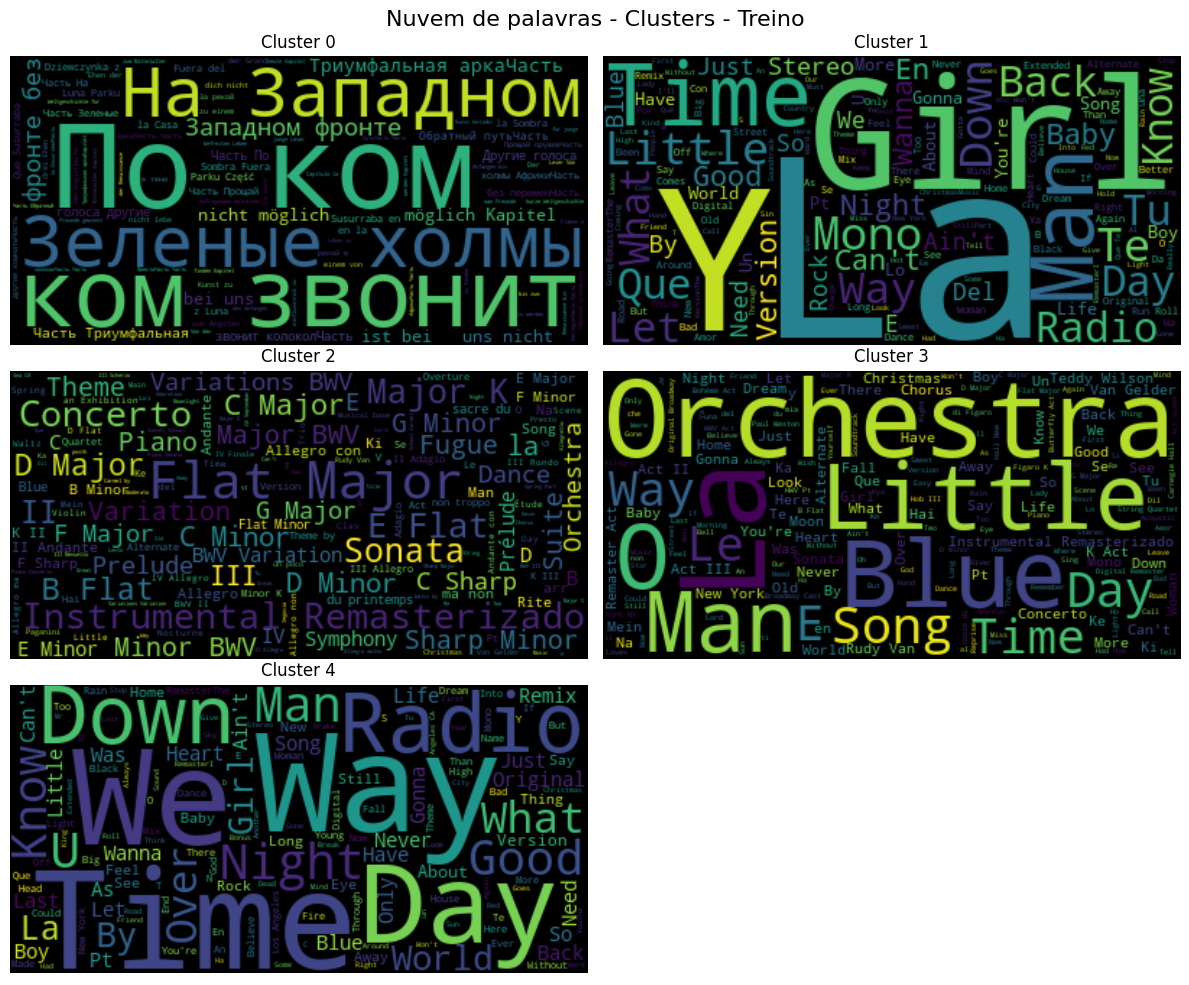

In [52]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(12,10), tight_layout=True)

lista_nuvens = [nuvem_cluster_0, nuvem_cluster_1, nuvem_cluster_2, nuvem_cluster_3, nuvem_cluster_4]

titulos = ["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4"]

palavras_ocultar = ['and','or','when','why','the','he','she','it','him','her','they','are','is','am','no','me',
                    'feat','to','a','from','for','at','with','that','feat','in','my','i','op','you','up','de',
                    'all','of','one','on','will','can','be','make','do','out','not','your','go','got','get','mi',
                    "i'm", 'el','live','remastered',"don't",'like','this','come','take','want','his','page','und','die','love','single']

for i, a, t in zip(lista_nuvens, ax.flat, titulos):
    wordcloud = WordCloud(stopwords=palavras_ocultar).generate(i)
    a.imshow(wordcloud, interpolation = 'bilinear')
    a.axis('off')
    a.set_title(t, fontsize=12)
    
plt.suptitle("Nuvem de palavras - Clusters - Treino", fontsize=16)
ax[2][1].axis('off')
plt.show()

#### **Visualizando as palavras presentes nos nomes das músicas, por Cluster - Base de teste**

In [53]:
cluster_0_teste = xteste.loc[xteste['Cluster'] == 0, "name"].to_list()
cluster_1_teste = xteste.loc[xteste['Cluster'] == 1, "name"].to_list()
cluster_2_teste = xteste.loc[xteste['Cluster'] == 2, "name"].to_list()
cluster_3_teste = xteste.loc[xteste['Cluster'] == 3, "name"].to_list()
cluster_4_teste = xteste.loc[xteste['Cluster'] == 4, "name"].to_list()

nuvem_cluster_0_teste = ''.join(map(str, cluster_0_teste))
nuvem_cluster_1_teste = ''.join(map(str, cluster_1_teste))
nuvem_cluster_2_teste = ''.join(map(str, cluster_2_teste))
nuvem_cluster_3_teste = ''.join(map(str, cluster_3_teste))
nuvem_cluster_4_teste = ''.join(map(str, cluster_4_teste))

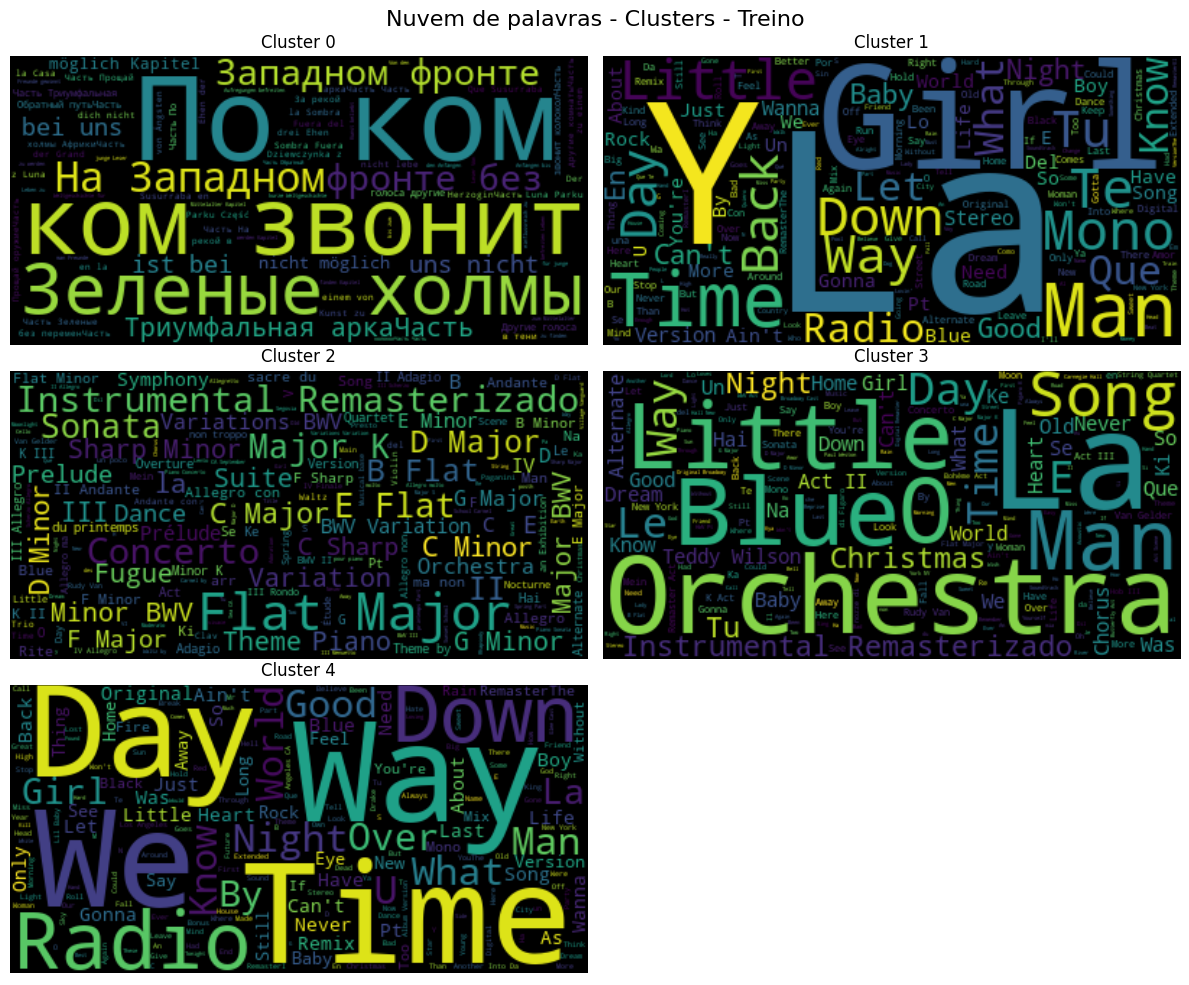

In [54]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(12,10), tight_layout=True)

lista_nuvens = [nuvem_cluster_0_teste, nuvem_cluster_1_teste, nuvem_cluster_2_teste, nuvem_cluster_3_teste, nuvem_cluster_4_teste]

titulos = ["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4"]

palavras_ocultar = ['and','or','when','why','the','he','she','it','him','her','they','are','is','am','no','me',
                    'feat','to','a','from','for','at','with','that','feat','in','my','i','op','you','up','de',
                    'all','of','one','on','will','can','be','make','do','out','not','your','go','got','get','mi',
                    "i'm", 'el','live','remastered',"don't",'like','this','come','take','want','his','page','und','die','love','single']

for i, a, t in zip(lista_nuvens, ax.flat, titulos):
    wordcloud = WordCloud(stopwords=palavras_ocultar).generate(i)
    a.imshow(wordcloud, interpolation = 'bilinear')
    a.axis('off')
    a.set_title(t, fontsize=12)
    
plt.suptitle("Nuvem de palavras - Clusters - Treino", fontsize=16)
ax[2][1].axis('off')
plt.show()